In [1]:
import numpy as np
import pickle

import tensorflow as tf
assert tf.__version__[0:4]=='1.15', 'Please install tensorflow 1.15.x'
import keras
assert keras.__version__[0:5]=='2.3.1', 'Please install keras 2.3.1'
from keras import backend as K

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['ytick.color'] = 'k'
mpl.rcParams['axes.labelcolor'] = 'k'

Using TensorFlow backend.


# Datasets and Models Loading

In [2]:
#Dataset Import
from keras.datasets import mnist
(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = mnist.load_data()

cifar_x_data = pickle.load(open('./data/Images/test_set_cifar_cnn_simple.p','rb'))
cifar_y_data = pickle.load(open('./data/Images/test_label_cifar_cnn_simple.p','rb'))

imagenet_x_data = pickle.load(open('./data/Images/imagenet50.p','rb'))
imagenet_y_data = pickle.load(open('./data/Images/imagenet50_labels.p','rb'))
imagenet_map = pickle.load(open('./data/Images/imagenet_mapping_labels.p','rb'))

In [3]:
#Dataset Shapes
print('MNIST Data Shape')
print(MNIST_x_data_test.shape)
print(MNIST_y_data_test.shape)
print()
print('cifar Data Shape')
print(cifar_x_data.shape)
print(cifar_y_data.shape)
print()
print('imagenet Data Shape')
print(imagenet_x_data.shape)

MNIST Data Shape
(10000, 28, 28)
(10000,)

cifar Data Shape
(10000, 32, 32, 3)
(10000,)

imagenet Data Shape
(50, 224, 224, 3)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_____________________________________

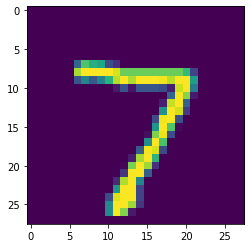

In [4]:
#Select model to analyse, unfortunately we had to use tensorflow 1.x version to mantain the compatibility among XAI methods,
#This led to the problem that we need to only have one model at time loaded into the kernel in orderf to obtain the gradients of only that model
#Run this cell every time you want to change model 

K.clear_session()
model_name = 'MNIST'

if model_name == 'MNIST':
    MNIST_CNN = keras.models.load_model('./models/Images/cnn_simple_mnist_no_pickle')
    MNIST_CNN.summary()
    MNIST_CNN.trainable=False
    print('MNIST Prediction Example')
    plt.imshow(MNIST_x_data_test[0,:].reshape(28,28))
    
    print('Prediction: ',np.where(MNIST_CNN.predict(MNIST_x_data_test[0,:].reshape(1,28,28,1))==1)[1])
elif model_name == 'cifar':
    cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    cifar_CNN = keras.models.load_model('./models/Images/cnn_simple_cifar_no_pickle')
    cifar_CNN.summary()
    cifar_CNN.trainable=False
    print('cifar Prediction Example')
    plt.imshow(cifar_x_data[0,:,:,:])
    print('Prediction: ',cifar_labels[int(np.argmax(cifar_CNN.predict(cifar_x_data[0:1,:,:,:]),axis=1))])
    
elif model_name == 'imagenet':
    print('imagenet Prediction Example')
    plt.imshow(imagenet_x_data[0,:]/255)
    imagenet_VGG = keras.applications.VGG16(input_shape=(224,224,3),include_top=True,weights='imagenet')
    imagenet_VGG.trainable=False
    y_hat = np.argmax(imagenet_VGG.predict(imagenet_x_data),axis=1)
    print('Prediction: ', imagenet_map[str(np.argmax(imagenet_VGG.predict(imagenet_x_data[0:1,:]).ravel()))][1])
    
else:
    raise Exception('Model name not recognized')

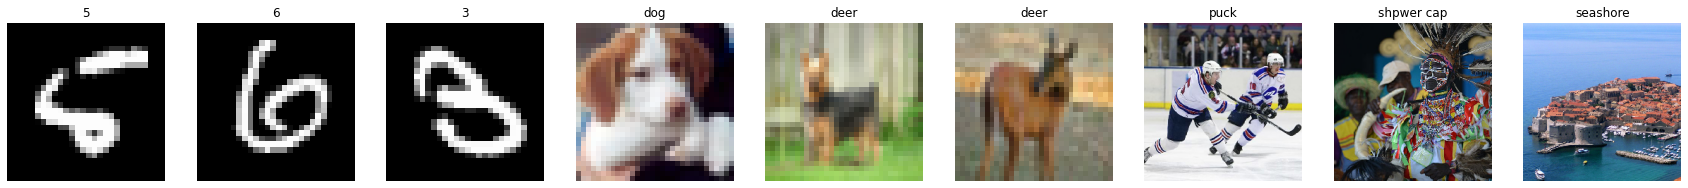

In [5]:
# Images used in the paper as examples
MNIST_test_idx = [8,11,18]
MNIST_y_hat = [5,6,3]
CIFAR_test_idx = [16,24,36]
CIFAR_y_hat = [5,4,4]
IMAGENET_test_idx = [3,7,9]
IMAGENET_y_hat = [746,793,978]
F,ax = plt.subplots(1,9,figsize=(30,3))

for i in range(9):
    ax[i].axis('off')

ax[0].imshow(MNIST_x_data_test[8:9,:].squeeze(0),cmap='gray')
ax[0].set_title('5')
ax[1].imshow(MNIST_x_data_test[11:12,:].squeeze(0),cmap='gray')
ax[1].set_title('6')
ax[2].imshow(MNIST_x_data_test[18:19,:].squeeze(0),cmap='gray')
ax[2].set_title('3')
ax[3].imshow(cifar_x_data[16:17,:].squeeze(0),cmap='gray')
ax[3].set_title('dog')
ax[4].imshow(cifar_x_data[24:25,:].squeeze(0),cmap='gray')
ax[4].set_title('deer')
ax[5].imshow(cifar_x_data[36:37,:].squeeze(0),cmap='gray')
ax[5].set_title('deer')
ax[6].imshow(imagenet_x_data[3:4,:].astype(int).squeeze(0))
ax[6].set_title('puck')
ax[7].imshow(imagenet_x_data[7:8,:].astype(int).squeeze(0))
ax[7].set_title('shpwer cap')
ax[8].imshow(imagenet_x_data[9:10,:].astype(int).squeeze(0))
ax[8].set_title('seashore');

# IntGrad

In [6]:
#import intgrad algorithm
from scripts.images.intgrad import *
import time

# plot function of intgrad values
def plot_img_attributions(model,
                          baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

    
    image_tensor = tf.convert_to_tensor(image)
    attributions = integrated_gradients(model,
                                        baseline=baseline,
                                        image=tf.cast(tf.reshape(image_tensor,(28,28,1)),tf.float32),
                                        target_class_idx=target_class_idx,
                                        m_steps=m_steps)
    
    start = time.time()
    output = K.get_session().run(attributions, feed_dict={image_tensor:image})

    # Sum of the attributions across color channels for visualization.
    # The attribution mask shape is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = np.sum(np.abs(output), axis=-1)

    print('time: ',time.time()-start)

    fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(10, 7))
    
    axs[0, 0].set_title('Example')
    axs[0, 0].imshow(image,cmap='gray')
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Attribution mask')
    axs[0, 1].imshow(attribution_mask, cmap=cmap)
    axs[0, 1].axis('off')

    axs[0, 2].set_title('Overlay')
    axs[0, 2].imshow(attribution_mask, cmap=cmap)
    axs[0, 2].imshow(image,cmap='gray',alpha=overlay_alpha)
    axs[0, 2].axis('off')

    plt.tight_layout()
    return fig

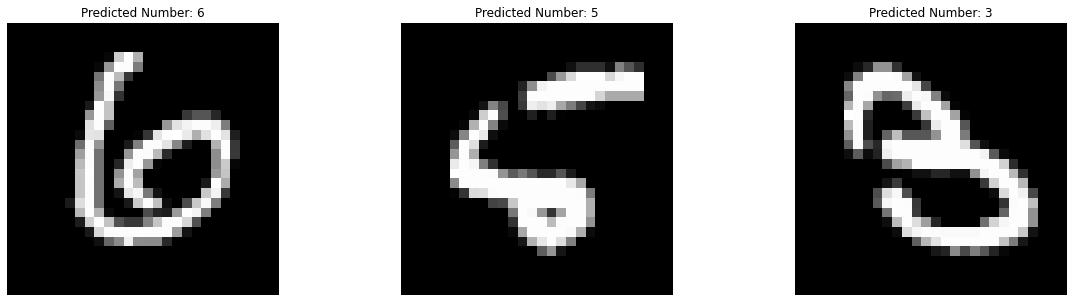

In [7]:
# Print the images we want to explain
img = [11,8,18]
F,ax=plt.subplots(1,len(img),figsize=(20,5))
ax = ax.ravel()
j = 0
i = 0
for i in range(len(img)):
    ax[j].set_title('Predicted Number: '+str(int(np.argmax(MNIST_CNN.predict(MNIST_x_data_test[img[i]:img[i]+1,:].reshape(1,28,28,1)/255)))))
    ax[j].imshow(MNIST_x_data_test[img[i],:],cmap='gray')
    ax[j].axis('off')
    j += 1


time:  0.35140490531921387
time:  0.3701608180999756
time:  0.36211609840393066


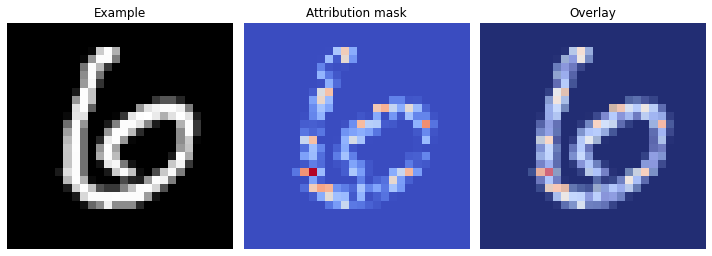

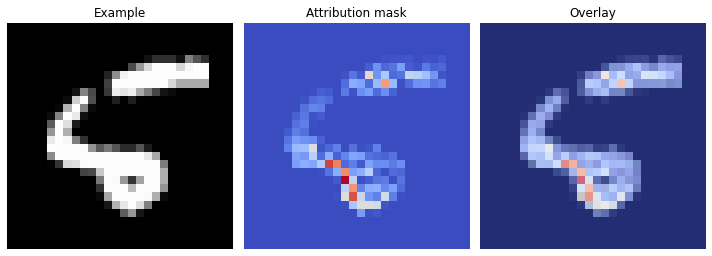

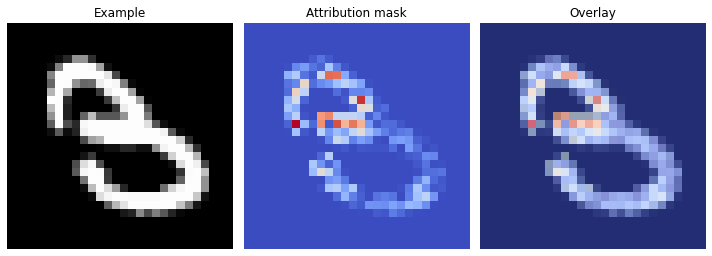

In [8]:
baseline = tf.zeros(shape=(28,28,1))

for idx in img:
    image = MNIST_x_data_test[idx,:]
    target = int(np.where(MNIST_CNN.predict(MNIST_x_data_test[img[i]:img[i]+1,:].reshape(1,28,28,1)))[1])

    #ig_attributions = integrated_gradients(cifar_CNN,
    #                                       baseline=baseline,
    #                                       image=image,
    #                                       target_class_idx=target,
    #                                       m_steps=240)

    F = plot_img_attributions(model=MNIST_CNN,
                            image=image,
                            baseline=baseline,
                            target_class_idx=target,
                            m_steps=240,
                            cmap=plt.cm.coolwarm,
                            overlay_alpha=0.4)

    #plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/intgrad/MNIST_{idx}_coolwarm.png')
    #plt.close()

In [ ]:
#F,ax=plt.subplots(14,5,figsize=(20,40))
#ax = ax.ravel()
#j = 0
#for i in range(len(ax)):
#    ax[i].imshow(cifar_x_data[j,:])
#    j += 1

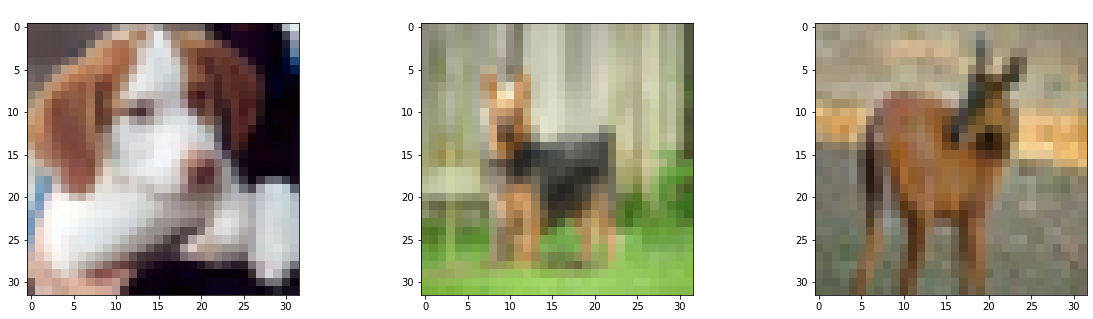

In [ ]:
img = [16,24,36]
F,ax=plt.subplots(1,len(img),figsize=(20,5))
ax = ax.ravel()
j = 0

for i in range(len(img)):
    ax[j].set_title(str(np.argmax(cifar_CNN.predict(cifar_x_data[img[i]:img[i]+1,:,:,:]),axis=1)[0]))
    ax[j].imshow(cifar_x_data[img[i],:])
    j += 1

In [ ]:
#[16,24,94,36,40]

for idx in img:
    baseline = tf.zeros(shape=(32,32,3))

    image = cifar_x_data[idx,:,:,:]
    target = int(np.argmax(cifar_CNN.predict(cifar_x_data[idx:idx+1,:,:,:]),axis=1)[0])

    #ig_attributions = integrated_gradients(cifar_CNN,
    #                                       baseline=baseline,
    #                                       image=image,
    #                                       target_class_idx=target,
    #                                       m_steps=240)

    F = plot_img_attributions(model=cifar_CNN,
                            image=image,
                            baseline=baseline,
                            target_class_idx=target,
                            m_steps=240,
                            cmap=plt.cm.coolwarm,
                            overlay_alpha=0.4)
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/intgrad/cifar_{idx}.png')
    plt.close()

time:  0.06707358360290527
time:  0.35590457916259766
time:  0.06761550903320312


In [ ]:
#img = list(range(20,50))
#F,ax=plt.subplots(int(np.ceil(np.sqrt(len(img)))),int(np.ceil(np.sqrt(len(img)))),figsize=(20,5*int(np.round(np.sqrt(len(img))))))
#ax = ax.ravel()
#j = 0
#
#for i in range(len(img)):
#    ax[j].set_title(imagenet_map[str(np.argmax(imagenet_VGG.predict(imagenet_x_data[img[i]:img[i]+1,:]).ravel()))][1])
#    ax[j].imshow(imagenet_x_data[img[i],:].astype(int))
#    j += 1

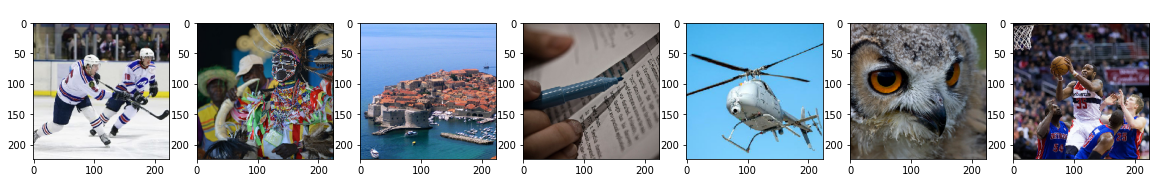

In [ ]:
img = [3,7,9,12,19,35,44]
F,ax=plt.subplots(1,len(img),figsize=(20,5))
ax = ax.ravel()
j = 0

for i in range(len(img)):
    ax[j].set_title(imagenet_map[str(np.argmax(imagenet_VGG.predict(imagenet_x_data[img[i]:img[i]+1,:]).ravel()))][1])
    ax[j].imshow(imagenet_x_data[img[i],:].astype(int))
    j += 1

In [ ]:
#[3,7,9,12,19,35,44]

for idx in img:
    baseline = tf.zeros(shape=(224,224,3))

    image = imagenet_x_data[idx,:,:,:]
    target = int(np.argmax(imagenet_VGG.predict(imagenet_x_data[idx:idx+1,:]).ravel()))

    #ig_attributions = integrated_gradients(imagenet_VGG,
    #                                       baseline=baseline,
    #                                       image=image,
    #                                       target_class_idx=target,
    #                                       m_steps=240)

    F = plot_img_attributions(model=imagenet_VGG,
                            image=tf.convert_to_tensor(image),
                            baseline=baseline,
                            target_class_idx=target,
                            m_steps=240,
                            cmap=plt.cm.coolwarm,
                            overlay_alpha=0.4)

    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/intgrad/imagenet_{idx}.png')
    plt.close()

time:  13.580771684646606
time:  4.750677108764648
time:  4.292970418930054
time:  4.755184173583984
time:  4.723039388656616
time:  4.734609842300415
time:  4.456661224365234


# DeepLift

you need to restart the session every time you change model because it is using tensorflow 1 session

In [7]:
pip install -e git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain

Obtaining deepexplain from git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain
  Updating ./src/deepexplain clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 87fb43a13ac2a3b285a030b87df899cc40100c94
  Found existing installation: deepexplain 0.3
    Can't uninstall 'deepexplain'. No files were found to uninstall.
  Running setup.py develop for deepexplain


In [8]:
from src.deepexplain.deepexplain.tensorflow import DeepExplain
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D

In [9]:
from skimage import feature, transform

def saliency_plot(data, xi=None, cmap='RdBu_r', axis=plt, percentile=100, dilation=3.0, alpha=0.8, use_quantiles=False):
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, data.shape[1], dx)
    yy = np.arange(0.0, data.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_xi = plt.get_cmap('Greys_r')
    cmap_xi.set_bad(alpha=0)
    overlay = None
    if xi is not None:
        # Compute edges (to overlay to heatmaps later)
        xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
        in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
        if use_quantiles:
            edges = feature.canny(in_image_upscaled,use_quantiles=True,high_threshold=0.9).astype(float)
        else: 
            edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges

    abs_max = np.percentile(np.abs(data), percentile)
    abs_min = abs_max

    if len(data.shape) == 3:
        data = np.mean(data, 2)
    axis.imshow(data, extent=extent, interpolation='none', cmap=cmap, vmin=-abs_min, vmax=abs_max)
    if overlay is not None:
       axis.imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
    axis.axis('off')
    return axis

In [11]:
np.argmax(MNIST_CNN.predict((MNIST_x_data_test[18,:].astype(np.float32)/255).reshape(1,28,28,1)))

3

In [12]:
# ----- MNIST -----
new_layer = Dense(10,name='new_dense')
inp = MNIST_CNN.layers[0].input
out = new_layer(MNIST_CNN.layers[-2].output)
model2 = Model(inp, out)
#model2.summary()
model2.layers[-1].set_weights(MNIST_CNN.layers[-1].get_weights())

img = [11,8,18]

with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model2.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    target_tensor = model2(input_tensor)
    
    xs = MNIST_x_data_test[img,:].reshape(-1,28,28,1).astype(np.float32)/255
    ys = np.eye(10)[np.array([6,5,3])]
    
    #attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    #attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    #attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    #attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    #attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)
    
    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    # attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=100)


import time
start = time.time()

for i in range(len(img)):
    F,ax=plt.subplots(3,1,figsize=(20,15))
    ax[0].set_title(np.argmax(MNIST_CNN.predict((MNIST_x_data_test[img[i],:].astype(np.float32)/255).reshape(1,28,28,1))))
    ax[0].axis('off')
    ax[0].imshow(MNIST_x_data_test[img[i],:],cmap='gray')
    saliency_plot(attributions_dl[i,:,:,0],axis=ax[1])
    saliency_plot(attributions_dl[i,:,:,0],xs[i],axis=ax[2])
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/Deeplift/MNIST_{img[i]}.png')
    plt.close()
    print(time.time()-start)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1.3185946941375732
1.982499361038208
2.5984463691711426


In [10]:
# ----- CIFAR -----
new_layer = Dense(10,name='new_dense')
inp = cifar_CNN.layers[0].input
out = new_layer(cifar_CNN.layers[-2].output)
model2 = Model(inp, out)
#model2.summary()
model2.layers[-1].set_weights(cifar_CNN.layers[-1].get_weights())

img = [16,24,36]

with DeepExplain(session=K.get_session()) as de: 
    input_tensor = model2.layers[0].input
    target_tensor = model2(input_tensor)
    
    xs = cifar_x_data[img,:].reshape(-1,32,32,3).astype(np.float32)
    ys = np.eye(10)[np.array([5,4,4])]
    
    attributions_dl = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)


import time
start = time.time()

for i in range(len(img)):
    F,ax=plt.subplots(3,1,figsize=(20,15))
    ax[0].set_title(np.argmax(cifar_CNN.predict((cifar_x_data[img[i],:].astype(np.float32)).reshape(1,32,32,3))))
    ax[0].axis('off')
    ax[0].imshow(cifar_x_data[img[i],:])
    saliency_plot(attributions_dl[i,:,:,0],axis=ax[1])
    saliency_plot(attributions_dl[i,:,:,0],xs[i]/255,axis=ax[2],use_quantiles=True)
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/Deeplift/cifar_{img[i]}.png')
    plt.close()
    print(time.time()-start)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0.7238969802856445
1.316774606704712
2.035907030105591


In [10]:
# ----- VGG -----
new_layer = Dense(1000,name='new_dense')
inp = imagenet_VGG.layers[0].input
out = new_layer(imagenet_VGG.layers[-2].output)
model2 = Model(inp, out)
#model2.summary()
model2.layers[-1].set_weights(imagenet_VGG.layers[-1].get_weights())

img = [3,7,9]


with DeepExplain(session=K.get_session()) as de:  
    input_tensor = model2.layers[0].input
    target_tensor = model2(input_tensor)
    
    xs = imagenet_x_data[img,:].reshape(-1,224,224,3).astype(np.float32)
    ys = np.eye(1000)[np.array([746,793,978])]
    
    attributions_dl = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)


import time
start = time.time()

for i in range(len(img)):
    F,ax=plt.subplots(3,1,figsize=(20,15))
    ax[0].set_title(np.argmax(imagenet_VGG.predict((imagenet_x_data[img[i],:].astype(np.float32)).reshape(1,224,224,3))))
    ax[0].axis('off')
    ax[0].imshow(imagenet_x_data[img[i],:]/255)
    saliency_plot(attributions_dl[i,:,:,0],axis=ax[1])
    saliency_plot(attributions_dl[i,:,:,0],xs[i]/255,axis=ax[2])
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/Deeplift/imagenet_{img[i]}.png')
    plt.close()
    print(time.time()-start)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1.5937488079071045
3.1751081943511963
4.677325010299683


# ɛ-LRP

In [ ]:
pip install -e git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain

Obtaining deepexplain from git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain
  Updating ./src/deepexplain clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 87fb43a13ac2a3b285a030b87df899cc40100c94
  Found existing installation: deepexplain 0.3
    Can't uninstall 'deepexplain'. No files were found to uninstall.
  Running setup.py develop for deepexplain


In [ ]:
from src.deepexplain.deepexplain.tensorflow import DeepExplain
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
from skimage import feature, transform

def saliency_plot(data, xi=None, cmap='RdBu_r', axis=plt, percentile=100, dilation=3.0, alpha=0.8, use_quantiles=False):
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, data.shape[1], dx)
    yy = np.arange(0.0, data.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_xi = plt.get_cmap('Greys_r')
    cmap_xi.set_bad(alpha=0)
    overlay = None
    if xi is not None:
        # Compute edges (to overlay to heatmaps later)
        xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
        in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
        if use_quantiles:
            edges = feature.canny(in_image_upscaled,use_quantiles=True,high_threshold=0.9).astype(float)
        else: 
            edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges

    abs_max = np.percentile(np.abs(data), percentile)
    abs_min = abs_max

    if len(data.shape) == 3:
        data = np.mean(data, 2)
    axis.imshow(data, extent=extent, interpolation='none', cmap=cmap, vmin=-abs_min, vmax=abs_max)
    if overlay is not None:
       axis.imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
    axis.axis('off')
    return axis

In [ ]:
# ----- MNIST -----
new_layer = Dense(10,name='new_dense')
inp = MNIST_CNN.layers[0].input
out = new_layer(MNIST_CNN.layers[-2].output)
model2 = Model(inp, out)
#model2.summary()
model2.layers[-1].set_weights(MNIST_CNN.layers[-1].get_weights())

img = [11,8,18]

with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model2.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    target_tensor = model2(input_tensor)
    
    xs = MNIST_x_data_test[img,:].reshape(-1,28,28,1).astype(np.float32)/255
    ys = np.eye(10)[np.array([6,5,3])]
    
    #attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    #attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    #attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    #attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    #attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)
    
    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    # attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=100)


import time
start = time.time()

for i in range(len(img)):
    F,ax=plt.subplots(3,1,figsize=(20,15))
    ax[0].set_title(np.argmax(MNIST_CNN.predict((MNIST_x_data_test[img[i],:].astype(np.float32)/255).reshape(1,28,28,1))))
    ax[0].axis('off')
    ax[0].imshow(MNIST_x_data_test[img[i],:],cmap='gray')
    saliency_plot(attributions_elrp[i,:,:,0],axis=ax[1])
    saliency_plot(attributions_elrp[i,:,:,0],xs[i],axis=ax[2])
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/eLRP/MNIST_{img[i]}.png')
    plt.close()
    print(time.time()-start)

1.1352577209472656
1.4707143306732178
1.8222177028656006


In [ ]:
# ----- CIFAR -----
new_layer = Dense(10,name='new_dense')
inp = cifar_CNN.layers[0].input
out = new_layer(cifar_CNN.layers[-2].output)
model2 = Model(inp, out)
#model2.summary()
model2.layers[-1].set_weights(cifar_CNN.layers[-1].get_weights())

img = [16,24,36]

with DeepExplain(session=K.get_session()) as de: 
    input_tensor = model2.layers[0].input
    target_tensor = model2(input_tensor)
    
    xs = cifar_x_data[img,:].reshape(-1,32,32,3).astype(np.float32)
    ys = np.eye(10)[np.array([5,4,4])]
    
    attributions_elrp = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)


import time
start = time.time()

for i in range(len(img)):
    F,ax=plt.subplots(3,1,figsize=(20,15))
    ax[0].set_title(np.argmax(cifar_CNN.predict((cifar_x_data[img[i],:].astype(np.float32)).reshape(1,32,32,3))))
    ax[0].axis('off')
    ax[0].imshow(cifar_x_data[img[i],:])
    saliency_plot(attributions_elrp[i,:,:,0],axis=ax[1])
    saliency_plot(attributions_elrp[i,:,:,0],xs[i]/255,axis=ax[2],use_quantiles=True)
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/eLRP/cifar_{img[i]}.png')
    plt.close()
    print(time.time()-start)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0.4327976703643799
0.7669296264648438
1.1014666557312012


In [ ]:
# ----- VGG -----
new_layer = Dense(1000,name='new_dense')
inp = imagenet_VGG.layers[0].input
out = new_layer(imagenet_VGG.layers[-2].output)
model2 = Model(inp, out)
#model2.summary()
model2.layers[-1].set_weights(imagenet_VGG.layers[-1].get_weights())

img = [3,7,9]


with DeepExplain(session=K.get_session()) as de:  
    input_tensor = model2.layers[0].input
    target_tensor = model2(input_tensor)
    
    xs = imagenet_x_data[img,:].reshape(-1,224,224,3).astype(np.float32)
    ys = np.eye(1000)[np.array([746,793,978])]
    
    attributions_elrp = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)


import time
start = time.time()

for i in range(len(img)):
    F,ax=plt.subplots(3,1,figsize=(20,15))
    ax[0].set_title(np.argmax(imagenet_VGG.predict((imagenet_x_data[img[i],:].astype(np.float32)).reshape(1,224,224,3))))
    ax[0].axis('off')
    ax[0].imshow(imagenet_x_data[img[i],:]/255)
    saliency_plot(attributions_elrp[i,:,:,0],axis=ax[1])
    saliency_plot(attributions_elrp[i,:,:,0],xs[i]/255,axis=ax[2])
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/eLRP/imagenet_{img[i]}.png')
    plt.close()
    print(time.time()-start)

1.138916254043579
2.3077046871185303
3.4695425033569336


# LIME

In [ ]:
!pip install lime

     |████████████████████████████████| 276kB 8.0MB/s eta 0:00:01
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=28851982a7128fdec719e3255dcf96cd7e845fed22b94fefffdac9eaef52e39d
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


LIME vuole immagine in RGB non supporta greyscale

In [ ]:
from lime import lime_image
import time

In [ ]:
explainer = lime_image.LimeImageExplainer(verbose = False)

In [ ]:
from skimage.color import gray2rgb, rgb2gray, label2rgb
img1 = gray2rgb(MNIST_x_data_test[8:9,:].squeeze(0))
img2 = gray2rgb(MNIST_x_data_test[11:12,:].squeeze(0))
img3 = gray2rgb(MNIST_x_data_test[18:19,:].squeeze(0))

def LIME_wrapper(image):
    image = rgb2gray(image).reshape(-1,28,28,1)
    return MNIST_CNN.predict(image)

F, ax = plt.subplots(3,1,figsize=(20,15))
i = 0

for img in [img1,img2,img3]:
    start = time.time()
    explanation = explainer.explain_instance(img, LIME_wrapper, top_labels=5, hide_color=0, num_samples=2000)
    print(time.time()-start)

    ax[0].imshow(img)
    ax[0].axis('off')

    #plot heatmap
    ind =  explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    ax[1].imshow(heatmap, cmap = 'coolwarm', vmin  = -heatmap.max(), vmax = heatmap.max())
    ax[1].axis('off')
    
    #plot overlap
    temp, mask = explanation.get_image_and_mask(MNIST_y_hat[i], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
    ax[2].imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    ax[2].axis('off')
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/LIME/MNIST_{MNIST_test_idx[i]}.png')
    i+=1
plt.close()


0.525000810623169



0.5320963859558105



0.528292179107666


In [ ]:
F, ax = plt.subplots(3,1,figsize=(20,15))
i = 0

for img in CIFAR_test_idx:
    start = time.time()
    explanation = explainer.explain_instance(cifar_x_data[img], cifar_CNN.predict, top_labels=5, hide_color=0, num_samples=2000)
    print(time.time()-start)

    ax[0].imshow(cifar_x_data[img])
    ax[0].axis('off')

    #plot heatmap
    ind =  explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    ax[1].imshow(heatmap, cmap = 'coolwarm', vmin  = -heatmap.max(), vmax = heatmap.max())
    ax[1].axis('off')
    
    #plot overlap
    temp, mask = explanation.get_image_and_mask(CIFAR_y_hat[i], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
    ax[2].imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    ax[2].axis('off')
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/LIME/CIFAR_{img}.png')
    i+=1
plt.close()


5.58492636680603



5.6355140209198



5.616211414337158


In [ ]:
from skimage.color import label2rgb

F, ax = plt.subplots(3,1,figsize=(20,15))
i = 0

for img in IMAGENET_test_idx:
    start = time.time()
    explanation = explainer.explain_instance(imagenet_x_data[img], imagenet_VGG.predict, top_labels=5, hide_color=0, num_samples=2000)
    print(time.time()-start)

    ax[0].imshow(imagenet_x_data[img].astype(int))
    ax[0].axis('off')

    #plot heatmap
    ind =  explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    ax[1].imshow(heatmap, cmap = 'coolwarm', vmin  = -heatmap.max(), vmax = heatmap.max())
    ax[1].axis('off')
    
    #plot overlap
    temp, mask = explanation.get_image_and_mask(IMAGENET_y_hat[i], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
    ax[2].imshow(temp.astype(int),alpha=0.5)
    ax[2].imshow(mask,alpha=0.5,cmap='coolwarm')
    ax[2].axis('off')
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/LIME/IMAGENET_{img}.png')
    i+=1
plt.close()


24.0349702835083



47.83216953277588



24.22445273399353


In [ ]:
pred_indexes = np.argsort(imagenet_VGG.predict(imagenet_x_data[7:8,:]).ravel())[-3:][::-1]
print(pred_indexes)
print([imagenet_map[str(pred_indexes[i])][1] for i in range(len(pred_indexes))])
print(imagenet_VGG.predict(imagenet_x_data[7:8,:]).ravel()[pred_indexes])

[793 643 883]
['shower_cap', 'mask', 'vase']
[0.25550866 0.21546829 0.07227119]


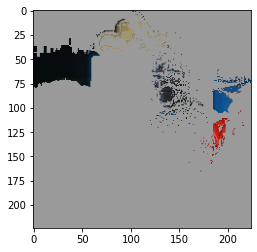

In [ ]:
explanation = explainer.explain_instance(imagenet_x_data[img], imagenet_VGG.predict, top_labels=3, num_samples=5000)

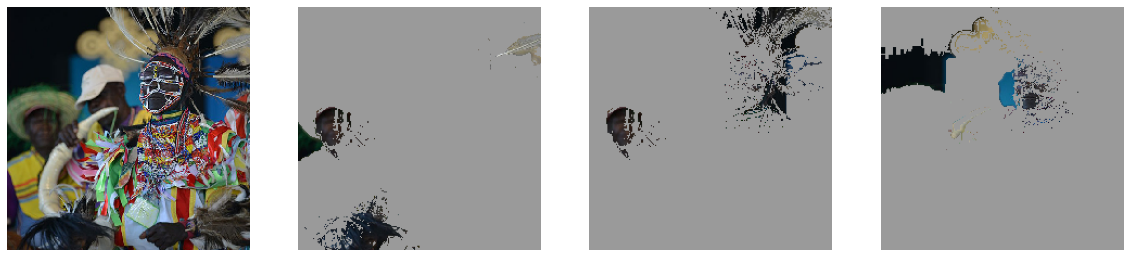

In [ ]:
from skimage.color import label2rgb

F, ax = plt.subplots(1,4,figsize=(20,15))
img = 7
ax[0].imshow(imagenet_x_data[7:8,:].astype(int).squeeze(0))
ax[0].axis('off')

for i in range(3):
    ind =  explanation.top_labels[i]
    #plot overlap
    temp, mask = explanation.get_image_and_mask(ind, positive_only=True, num_features=5, hide_rest=True, min_weight = 0.001)
    ax[i+1].imshow(imagenet_x_data[7:8].astype(int).squeeze(0)*np.repeat(mask[:,:,np.newaxis],3,axis=2).astype(int)+np.repeat((np.abs(mask-1)*154)[:,:,np.newaxis],3,axis=2))
    ax[i+1].axis('off')

# SmoothGrad

In [ ]:
!pip install saliency

In [ ]:
MNIST_test_idx = [8,11,18]
MNIST_y_hat = [5,6,3]

graph = K.get_session().graph

with graph.as_default():
  images = MNIST_CNN.inputs[0]
  sess = K.get_session()
    
  # Construct the scalar neuron tensor.
  logits = MNIST_CNN.get_output_at(-1)[0]
  neuron_selector = tf.placeholder(tf.int32)
  y = logits[neuron_selector]
    
  # Construct tensor for predictions.
  prediction = tf.argmax(logits,axis=0)

import saliency
import time
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = saliency.GradientSaliency(graph, sess, y, images)

F,ax = plt.subplots(3,1,figsize=(20,15))

for idx in MNIST_test_idx:

    # Load the image
    im = (MNIST_x_data_test[idx:idx+1,:]/255)

    # Show the image
    ax[0].imshow(im.reshape(28,28),cmap='gray')
    ax[0].axis('off')

    start = time.time()
    # Make a prediction. 
    prediction_class = sess.run(prediction, feed_dict = {images: [im.reshape(28,28,1)]})

    # Compute the vanilla mask and the smoothed mask.
    vanilla_mask_3d = gradient_saliency.GetMask(im.reshape(28,28,1), feed_dict = {neuron_selector: prediction_class})
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im.reshape(28,28,1), feed_dict = {neuron_selector: prediction_class})
    print(prediction_class, time.time()-start)

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

    #ax[0].imshow(vanilla_mask_grayscale,cmap='gray')
    ax[2].imshow(smoothgrad_mask_grayscale,cmap='coolwarm')
    ax[2].axis('off')

    #ax[2].imshow(im.reshape(28,28),cmap='gray',alpha=0.5)
    #ax[2].imshow(smoothgrad_mask_grayscale,cmap='coolwarm',alpha=0.5)
    #ax[2].axis('off')
    ax[1].imshow(vanilla_mask_grayscale,cmap='coolwarm')
    ax[1].axis('off')
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/SmoothGrad/MNIST_{idx}_v2.png')

plt.close()

5 0.1430950164794922
6 0.04730582237243652
3 0.047760009765625


In [ ]:
CIFAR_test_idx = [16,24,36]
CIFAR_y_hat = [5,4,4]

graph = K.get_session().graph

with graph.as_default():
  images = cifar_CNN.inputs[0]
  sess = K.get_session()
    
  # Construct the scalar neuron tensor.
  logits = cifar_CNN.get_output_at(-1)[0]
  neuron_selector = tf.placeholder(tf.int32)
  y = logits[neuron_selector]
    
  # Construct tensor for predictions.
  prediction = tf.argmax(logits,axis=0)

import saliency
import time 
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = saliency.GradientSaliency(graph, sess, y, images)

F,ax = plt.subplots(3,1,figsize=(20,15))

for idx in CIFAR_test_idx:
    # Load the image
    im = (cifar_x_data[idx:idx+1,:])

    # Show the image
    ax[0].imshow(im.squeeze(0))
    ax[0].axis('off')

    start = time.time()
    # Make a prediction. 
    prediction_class = sess.run(prediction, feed_dict = {images: [im.reshape(32,32,3)]})

    # Compute the vanilla mask and the smoothed mask.
    vanilla_mask_3d = gradient_saliency.GetMask(im.reshape(32,32,3), feed_dict = {neuron_selector: prediction_class})
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im.reshape(32,32,3), feed_dict = {neuron_selector: prediction_class})

    print(prediction_class, time.time()-start)

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

    #ax[0].imshow(vanilla_mask_grayscale,cmap='gray')
    ax[2].imshow(smoothgrad_mask_grayscale,cmap='coolwarm')
    ax[2].axis('off')

    #ax[2].imshow(im.squeeze(0),cmap='gray',alpha=0.7)
    #ax[2].imshow(smoothgrad_mask_grayscale,cmap='coolwarm',alpha=0.3)
    ax[1].imshow(vanilla_mask_grayscale,cmap='coolwarm')
    ax[1].axis('off')
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/SmoothGrad/CIFAR_{idx}_v2.png')

plt.close()

5 0.33516526222229004
4 0.07275128364562988
4 0.06970715522766113


In [ ]:
IMAGENET_test_idx = [3,7,9]
IMAGENET_y_hat = [746,793,978]

graph = K.get_session().graph

with graph.as_default():
  images = imagenet_VGG.inputs[0]
  sess = K.get_session()
    
  # Construct the scalar neuron tensor.
  logits = imagenet_VGG.get_output_at(-1)[0]
  neuron_selector = tf.placeholder(tf.int32)
  y = logits[neuron_selector]
    
  # Construct tensor for predictions.
  prediction = tf.argmax(logits,axis=0)

import saliency
import time 
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = saliency.GradientSaliency(graph, sess, y, images)

F,ax = plt.subplots(3,1,figsize=(20,15))

for idx in IMAGENET_test_idx:
    # Load the image
    im = (imagenet_x_data[idx:idx+1,:])

    # Show the image
    ax[0].imshow(im.squeeze(0).astype(int))
    ax[0].axis('off')

    start = time.time()
    # Make a prediction. 
    prediction_class = sess.run(prediction, feed_dict = {images: [im.reshape(224,224,3)]})

    # Compute the vanilla mask and the smoothed mask.
    vanilla_mask_3d = gradient_saliency.GetMask(im.reshape(224,224,3), feed_dict = {neuron_selector: prediction_class})
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im.reshape(224,224,3), feed_dict = {neuron_selector: prediction_class})

    print(prediction_class, time.time()-start)

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

    #ax[0].imshow(vanilla_mask_grayscale,cmap='gray')
    ax[2].imshow(smoothgrad_mask_grayscale,cmap='coolwarm')
    ax[2].axis('off')

    #ax[2].imshow(im.squeeze(0).astype(int),cmap='gray',alpha=0.7)
    #ax[2].imshow(smoothgrad_mask_grayscale,cmap='coolwarm',alpha=0.3)
    ax[1].imshow(vanilla_mask_grayscale,cmap='coolwarm')
    ax[1].axis('off')
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/SmoothGrad/IMAGENET_{idx}_v2.png')

plt.close()

746 0.881615400314331
793 0.6998698711395264
978 0.6991293430328369


# XRAI

In [ ]:
!pip install saliency

In [ ]:
graph = K.get_session().graph

with graph.as_default():
  images = MNIST_CNN.inputs[0]
  sess = K.get_session()
    
  # Construct the scalar neuron tensor.
  logits = MNIST_CNN.get_output_at(-1)[0]
  neuron_selector = tf.placeholder(tf.int32)
  y = logits[neuron_selector]
    
  # Construct tensor for predictions.
  prediction = tf.argmax(logits,axis=0)

import saliency
import time
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
xrai_object = saliency.XRAI(graph, sess, y, images)

F,ax = plt.subplots(3,1,figsize=(20,15))

for idx in MNIST_test_idx:

    # Load the image
    im = (MNIST_x_data_test[idx:idx+1,:]/255)

    # Show the image
    ax[0].imshow(im.reshape(28,28),cmap='gray')
    ax[0].axis('off')

    start = time.time()
    # Make a prediction. 
    prediction_class = sess.run(prediction, feed_dict = {images: [im.reshape(28,28,1)]})

    # Compute the vanilla mask and the smoothed mask.
    #vanilla_mask_3d = gradient_saliency.GetMask(im.reshape(28,28,1), feed_dict = {neuron_selector: prediction_class})
    xrai_attributions = xrai_object.GetMask(im.reshape(28,28,1), feed_dict={neuron_selector: prediction_class})
    print(prediction_class, time.time()-start)
    
    ax[1].imshow(xrai_attributions,cmap='coolwarm')
    ax[1].axis('off')

    mask = xrai_attributions > np.percentile(xrai_attributions, 70)
    im_mask = np.array(im.squeeze(0))
    im_mask[~mask] = 0.3
    ax[2].imshow(im_mask,cmap='gray')
    ax[2].axis('off')
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/XRAI/MNIST_{idx}.png')

plt.close()

5 2.109168529510498
6 1.1756725311279297
3 1.0347154140472412


In [ ]:
graph = K.get_session().graph

with graph.as_default():
  images = cifar_CNN.inputs[0]
  sess = K.get_session()
    
  # Construct the scalar neuron tensor.
  logits = cifar_CNN.get_output_at(-1)[0]
  neuron_selector = tf.placeholder(tf.int32)
  y = logits[neuron_selector]
    
  # Construct tensor for predictions.
  prediction = tf.argmax(logits,axis=0)

import saliency
import time 
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
xrai_object = saliency.XRAI(graph, sess, y, images)

F,ax = plt.subplots(3,1,figsize=(20,15))

for idx in CIFAR_test_idx:
    # Load the image
    im = (cifar_x_data[idx:idx+1,:])

    # Show the image
    ax[0].imshow(im.squeeze(0))
    ax[0].axis('off')

    start = time.time()
    # Make a prediction. 
    prediction_class = sess.run(prediction, feed_dict = {images: [im.reshape(32,32,3)]})

    # Compute the vanilla mask and the smoothed mask.
    xrai_attributions = xrai_object.GetMask(im.reshape(32,32,3), feed_dict={neuron_selector: prediction_class})
    print(prediction_class, time.time()-start)

    ax[1].imshow(xrai_attributions,cmap='coolwarm')
    ax[1].axis('off')

    mask = xrai_attributions > np.percentile(xrai_attributions, 70)
    im_mask = np.array(im.squeeze(0))
    im_mask[~mask] = 0.3
    ax[2].imshow(im_mask,cmap='gray')
    ax[2].axis('off')
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/XRAI/CIFAR_{idx}.png')

plt.close()

5 2.6647870540618896
4 1.4195117950439453
4 1.3904988765716553


In [ ]:
graph = K.get_session().graph

with graph.as_default():
  images = imagenet_VGG.inputs[0]
  sess = K.get_session()
    
  # Construct the scalar neuron tensor.
  logits = imagenet_VGG.get_output_at(-1)[0]
  neuron_selector = tf.placeholder(tf.int32)
  y = logits[neuron_selector]
    
  # Construct tensor for predictions.
  prediction = tf.argmax(logits,axis=0)

import saliency
import time 
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
xrai_object = saliency.XRAI(graph, sess, y, images)

F,ax = plt.subplots(3,1,figsize=(20,15))

for idx in IMAGENET_test_idx:
    # Load the image
    im = (imagenet_x_data[idx:idx+1,:])

    # Show the image
    ax[0].imshow(im.squeeze(0).astype(int))
    ax[0].axis('off')

    start = time.time()
    # Make a prediction. 
    prediction_class = sess.run(prediction, feed_dict = {images: [im.reshape(224,224,3)]})

    # Compute the vanilla mask and the smoothed mask.
    xrai_attributions = xrai_object.GetMask(im.reshape(224,224,3), feed_dict={neuron_selector: prediction_class})
    print(prediction_class, time.time()-start)

    ax[1].imshow(xrai_attributions,cmap='coolwarm')
    ax[1].axis('off')

    mask = xrai_attributions > np.percentile(xrai_attributions, 70)
    im_mask = np.array(im.squeeze(0))
    im_mask[~mask] = 0.3
    ax[2].imshow(im_mask.astype(int),cmap='gray')
    ax[2].axis('off')
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/XRAI/IMAGENET_{idx}.png')

plt.close()

746 19.041845321655273
793 18.286166429519653
978 15.257750988006592


# GradCAM and GradCAM++

In [ ]:
!wget https://raw.githubusercontent.com/totti0223/gradcamplusplus/master/gradcamutils.py
#https://github.com/totti0223/gradcamplusplus

--2020-10-21 12:35:14--  https://raw.githubusercontent.com/totti0223/gradcamplusplus/master/gradcamutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2918 (2.8K) [text/plain]
Saving to: ‘gradcamutils.py’

gradcamutils.py     100%[===================>]   2.85K  --.-KB/s    in 0s      

2020-10-21 12:35:14 (63.9 MB/s) - ‘gradcamutils.py’ saved [2918/2918]



In [ ]:
import gradcamutils 
import time

fig, ax = plt.subplots(6,1,figsize=(20,30))

for idx in MNIST_test_idx:
    img = MNIST_x_data_test[idx]
    predictions = MNIST_CNN.predict(img.reshape(1,28,28,1)/255)

    start = time.time()
    gradcam=gradcamutils.grad_cam(MNIST_CNN,img.reshape(1,28,28,1)/255,layer_name='conv2d_2',H=28,W=28)
    gradcamplus=gradcamutils.grad_cam_plus(MNIST_CNN,img.reshape(1,28,28,1)/255,layer_name='conv2d_2',H=28,W=28)

    print(np.argmax(predictions), time.time()-start)

    ax[0].imshow(img,cmap='gray')
    ax[0].axis('off')

    ax[1].imshow(gradcam,cmap="jet")
    ax[1].axis('off')

    ax[2].imshow(img, alpha=0.9, cmap='gray')
    ax[2].imshow(gradcam,alpha=0.4,cmap="jet")
    ax[2].axis('off')

    ax[3].imshow(img,cmap='gray')
    ax[3].axis('off')

    ax[4].imshow(gradcamplus,cmap="jet")
    ax[4].axis('off')

    ax[5].imshow(img, alpha=0.9, cmap='gray')
    ax[5].imshow(gradcamplus,alpha=0.4,cmap="jet")
    ax[5].axis('off')
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/GradCam/MNIST_{idx}.png')

plt.close()

5 0.5063490867614746
6 0.51882004737854
3 0.5403532981872559


In [ ]:
cifar_CNN.inputs

[<tf.Tensor 'conv2d_1_input:0' shape=(?, 32, 32, 3) dtype=float32>]

In [ ]:
import gradcamutils 
import time

fig, ax = plt.subplots(6,1,figsize=(20,30))

for idx in CIFAR_test_idx:
    img = cifar_x_data[idx]
    predictions = cifar_CNN.predict(img.reshape(1,32,32,3))

    start = time.time()
    gradcam=gradcamutils.grad_cam(cifar_CNN,img.reshape(1,32,32,3),layer_name='conv2d_6',H=32,W=32)
    gradcamplus=gradcamutils.grad_cam_plus(cifar_CNN,img.reshape(1,32,32,3),layer_name='conv2d_6',H=32,W=32)

    print(np.argmax(predictions), time.time()-start)

    ax[0].imshow(img)
    ax[0].axis('off')

    ax[1].imshow(gradcam,cmap="jet")
    ax[1].axis('off')

    ax[2].imshow(img, alpha=0.9)
    ax[2].imshow(gradcam,alpha=0.4,cmap="jet")
    ax[2].axis('off')

    ax[3].imshow(img)
    ax[3].axis('off')

    ax[4].imshow(gradcamplus,cmap="jet")
    ax[4].axis('off')

    ax[5].imshow(img, alpha=0.9)
    ax[5].imshow(gradcamplus,alpha=0.4,cmap="jet")
    ax[5].axis('off')
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/GradCam/CIFAR_{idx}.png')

plt.close()

5 0.2799844741821289
4 0.288649320602417
4 0.30613017082214355


In [ ]:
imagenet_VGG.inputs

[<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>]

In [ ]:
import gradcamutils 
import time

fig, ax = plt.subplots(6,1,figsize=(20,30))

for idx in IMAGENET_test_idx:
    img = imagenet_x_data[idx]
    predictions = imagenet_VGG.predict(img.reshape(1,224,224,3))

    start = time.time()
    gradcam=gradcamutils.grad_cam(imagenet_VGG,img.reshape(1,224,224,3),layer_name='block5_conv3',H=224,W=224)
    gradcamplus=gradcamutils.grad_cam_plus(imagenet_VGG,img.reshape(1,224,224,3),layer_name='block5_conv3',H=224,W=224)

    print(np.argmax(predictions), time.time()-start)

    ax[0].imshow(img.astype(int))
    ax[0].axis('off')

    ax[1].imshow(gradcam,cmap="jet")
    ax[1].axis('off')

    ax[2].imshow(img.astype(int), alpha=0.9)
    ax[2].imshow(gradcam,alpha=0.4,cmap="jet")
    ax[2].axis('off')

    ax[3].imshow(img.astype(int))
    ax[3].axis('off')

    ax[4].imshow(gradcamplus,cmap="jet")
    ax[4].axis('off')

    ax[5].imshow(img.astype(int), alpha=0.9)
    ax[5].imshow(gradcamplus,alpha=0.4,cmap="jet")
    ax[5].axis('off')
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/GradCam/IMAGENET_{idx}.png')

plt.close()

746 0.2068331241607666
793 0.20402169227600098
978 0.20447516441345215


# RISE

In [ ]:
from skimage.transform import resize
from tqdm import tqdm
import time

In [ ]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in range(N):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size, 1)
    return masks

batch_size = 100

def explain(model, inp, masks):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in range(0, N, batch_size):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    del preds
    sal = sal / N / p1
    return sal

In [ ]:
### MNIST ###
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = MNIST_CNN
        self.input_size = (28, 28)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

model = Model()
fig, ax = plt.subplots(3,1,figsize=(20,15))
i = 0

for idx in MNIST_test_idx:
    img = MNIST_x_data_test[idx]
    N = 2000
    s = 8
    p1 = 0.5
    
    start = time.time()
    masks = generate_masks(N, s, p1)
    sal = explain(model, img.reshape(28,28,1)/255, masks)
    print(time.time()-start)
    
    ax[0].imshow(img,cmap='gray')
    ax[0].axis('off')
    
    ax[1].imshow(sal[MNIST_y_hat[i]],cmap='jet')
    ax[1].axis('off')
    
    ax[2].imshow(img,cmap='gray')
    ax[2].imshow(sal[MNIST_y_hat[i]],cmap='jet',alpha=0.5)
    ax[2].axis('off')

    i+=1
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/RISE/MNIST_{idx}.png')
plt.close()

In [ ]:
### CIFAR ###
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = cifar_CNN
        self.input_size = (32, 32)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

model = Model()
fig, ax = plt.subplots(3,1,figsize=(20,15))
i = 0

for idx in CIFAR_test_idx:
    img = cifar_x_data[idx]
    N = 2000
    s = 8
    p1 = 0.5
    
    start = time.time()
    masks = generate_masks(N, s, p1)
    sal = explain(model, img.reshape(32,32,3), masks)
    print(time.time()-start)
    
    ax[0].imshow(img,cmap='gray')
    ax[0].axis('off')
    
    ax[1].imshow(sal[CIFAR_y_hat[i]],cmap='jet')
    ax[1].axis('off')
    
    ax[2].imshow(img,cmap='gray')
    ax[2].imshow(sal[CIFAR_y_hat[i]],cmap='jet',alpha=0.5)
    ax[2].axis('off')

    i+=1
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/RISE/CIFAR_{idx}.png')
plt.close()

Explaining: 100%|██████████| 20/20 [00:01<00:00, 13.12it/s]


3.456002712249756


Explaining: 100%|██████████| 20/20 [00:00<00:00, 112.04it/s]


2.0712733268737793


Explaining: 100%|██████████| 20/20 [00:00<00:00, 109.04it/s]


2.070342779159546


In [ ]:
### IMAGENET ###
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = imagenet_VGG
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

model = Model()
fig, ax = plt.subplots(3,1,figsize=(20,15))
i = 0

for idx in IMAGENET_test_idx:
    img = imagenet_x_data[idx]
    N = 2000
    s = 8
    p1 = 0.5
    
    start = time.time()
    masks = generate_masks(N, s, p1)
    sal = explain(model, img.reshape(224,224,3), masks)
    print(time.time()-start)
    
    ax[0].imshow(img.astype(int),cmap='gray')
    ax[0].axis('off')
    
    ax[1].imshow(sal[IMAGENET_y_hat[i]],cmap='jet')
    ax[1].axis('off')
    
    ax[2].imshow(img.astype(int),cmap='gray')
    ax[2].imshow(sal[IMAGENET_y_hat[i]],cmap='jet',alpha=0.5)
    ax[2].axis('off')

    i+=1
    plt.savefig(f'/content/drive/My Drive/XAI/XAI Survey/code/examples/RISE/IMAGENET_{idx}.png')
plt.close()

Explaining: 100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


21.42834734916687


Explaining: 100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


21.462854385375977


Explaining: 100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


21.53663969039917


In [ ]:
### IMAGENET ###
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = imagenet_VGG
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

saliency = []
import gc

for i in tqdm(range(40,50)):
    gc.collect()
    K.clear_session()
    tf.reset_default_graph()
    imagenet_VGG=keras.applications.VGG16(input_shape=(224,224,3),include_top=True,weights='imagenet')
    imagenet_VGG.trainable=False
    model = Model()
    
    img = imagenet_x_data[i]
    N = 2000
    s = 8
    p1 = 0.5
    
    masks = generate_masks(N, s, p1)
    saliency.append(explain(model, img.reshape(224,224,3), masks)[y_hat[i],:])

saliency = np.stack(saliency,axis=0)

100%|██████████| 10/10 [04:41<00:00, 28.15s/it]


In [ ]:
np.save('/content/drive/My Drive/XAI/XAI Survey/code/XAI_Scores/Images/imagenet_RISE_5',saliency)

In [ ]:
import numpy as np
saliency = []
for i in range(1,6):
    saliency.append(np.load('/content/drive/My Drive/XAI/XAI Survey/code/XAI_Scores/Images/imagenet_RISE_'+str(i)+'.npy'))
saliency = np.vstack(saliency)
np.save('/content/drive/My Drive/XAI/XAI Survey/code/XAI_Scores/Images/imagenet_RISE',saliency)

# TCAV

In [ ]:
!rm -r /content/tcav
!git clone https://github.com/tensorflow/tcav.git tcav
%cd tcav
!ls -l

Cloning into 'tcav'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 608 (delta 2), reused 4 (delta 1), pack-reused 592
Receiving objects: 100% (608/608), 562.56 KiB | 7.21 MiB/s, done.
Resolving deltas: 100% (365/365), done.
/content/tcav
total 152
-rw-r--r-- 1 root root  1101 Oct 23 14:52  CONTRIBUTING.md
-rw-r--r-- 1 root root  1716 Oct 23 14:52  FetchDataAndModels.sh
-rw-r--r-- 1 root root 11358 Oct 23 14:52  LICENSE
-rw-r--r-- 1 root root  3937 Oct 23 14:52  README.md
-rw-r--r-- 1 root root   129 Oct 23 14:52  requirements.txt
-rw-r--r-- 1 root root 61259 Oct 23 14:52 'Run TCAV.ipynb'
-rw-r--r-- 1 root root 56011 Oct 23 14:52  Run_TCAV_on_colab.ipynb
-rw-r--r-- 1 root root  1397 Oct 23 14:52  setup.py
drwxr-xr-x 4 root root  4096 Oct 23 14:52  tcav


In [ ]:
#%cd tcav
#!pwd

In [ ]:
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot # utils_plot requires matplotlib
import os 
import tensorflow as tf

In [ ]:
# first we need concepts
#from skimage.transform import rescale, resize
#from matplotlib import image
#import os
#
#for concept in ['soil','garden','grass']:
#    path = '/content/drive/My Drive/XAI/XAI Survey/code/examples/TCAV/'+concept
#    data = [] 
#    for el in os.listdir(path):
#        if el[-4:] == '.jpg':
#            img = image.imread(path+'/'+el)
#            image_resized = resize(img, (32, 32), anti_aliasing=True)
#            data.append(image_resized)
#    pickle.dump(np.stack(data),open('/content/drive/My Drive/XAI/XAI Survey/code/examples/TCAV/'+concept+'.pck','wb'))

#r = np.random.permutation(8000)
#random_x = cifar_x_data[~np.logical_or(cifar_y_data==4,cifar_y_data==5)][r]
#random_y = cifar_y_data[~np.logical_or(cifar_y_data==4,cifar_y_data==5)][r]
#print(random_x.shape)
#pickle.dump(np.stack(random_x),open('/content/drive/My Drive/XAI/XAI Survey/code/examples/TCAV/random_x.pck','wb'))
#pickle.dump(np.stack(random_y),open('/content/drive/My Drive/XAI/XAI Survey/code/examples/TCAV/random_y.pck','wb'))
#r = np.random.permutation(1000)
#positive_x = cifar_x_data[cifar_y_data==5][r][:100]
#print(positive_x.shape)
#pickle.dump(np.stack(positive_x),open('/content/drive/My Drive/XAI/XAI Survey/code/examples/TCAV/positive.pck','wb'))

In [ ]:
soil = pickle.load(open('/content/drive/My Drive/XAI/XAI Survey/code/examples/TCAV/soil.pck','rb'))
grass = pickle.load(open('/content/drive/My Drive/XAI/XAI Survey/code/examples/TCAV/grass.pck','rb'))
garden = pickle.load(open('/content/drive/My Drive/XAI/XAI Survey/code/examples/TCAV/garden.pck','rb'))
random_x = pickle.load(open('/content/drive/My Drive/XAI/XAI Survey/code/examples/TCAV/random_x.pck','rb'))
random_y = pickle.load(open('/content/drive/My Drive/XAI/XAI Survey/code/examples/TCAV/random_y.pck','rb'))
positive = pickle.load(open('/content/drive/My Drive/XAI/XAI Survey/code/examples/TCAV/positive.pck','rb'))
print(soil.shape)
print(grass.shape)
print(garden.shape)
print(random_x.shape)
print(random_y.shape)
print(positive.shape)

(70, 32, 32, 3)
(61, 32, 32, 3)
(90, 32, 32, 3)
(8000, 32, 32, 3)
(8000,)
(100, 32, 32, 3)


In [ ]:
if 'tcav_test' not in os.listdir('/content'):
    #create image folders
    i = 0
    os.system('mkdir /content/tcav_test')
    os.system('mkdir /content/tcav_test/images')

    os.system('mkdir /content/tcav_test/images/grass')
    for img in grass:
        plt.imshow(img)
        plt.axis('off')
        plt.savefig('/content/tcav_test/images/grass/grass_'+str(i)+'.jpg',bbox_inches = 'tight',pad_inches=0)
        i+=1
        plt.close()

    os.system('mkdir /content/tcav_test/images/garden')
    for img in garden:
        plt.imshow(img)
        plt.axis('off')
        plt.savefig('/content/tcav_test/images/garden/garden_'+str(i)+'.jpg',bbox_inches = 'tight',pad_inches=0)
        i+=1
        plt.close()

    os.system('mkdir /content/tcav_test/images/soil')
    for img in soil:
        plt.imshow(img)
        plt.axis('off')
        plt.savefig('/content/tcav_test/images/soil/soil_'+str(i)+'.jpg',bbox_inches = 'tight',pad_inches=0)
        i+=1
        plt.close()

    os.system('mkdir /content/tcav_test/images/deer')
    for img in positive:
        plt.imshow(img)
        plt.axis('off')
        plt.savefig('/content/tcav_test/images/deer/deer_'+str(i)+'.jpg',bbox_inches = 'tight',pad_inches=0)
        i+=1
        plt.close()

    r = np.random.permutation(8000)

    for i in range(10):
        os.system('mkdir /content/tcav_test/images/random500_'+str(i))
        j = 0
        tcav_test = random_x[r[i*10:(i+1)*10]]
        for img in tcav_test:
            plt.imshow(img)
            plt.axis('off')
            plt.savefig('/content/tcav_test/images/random500_'+str(i)+'/random_'+str(j)+'.jpg',bbox_inches = 'tight',pad_inches=0)
            j+=1
            plt.close()

    #save the model
    cifar_CNN.save('/content/tcav_test/model.pb') 

    #create label file
    labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    for l in labels:
        with open('/content/tcav_test/label_strings.txt','a') as file:
            file.write(l+'\n')


In [ ]:
# the name of the parent directory that results are stored (only if you want to cache)
project_name = 'tcav_class_test'
working_dir = '/content/tcav_test'
# where activations are stored (only if your act_gen_wrapper does so)
activation_dir =  working_dir+ '/activations/'
# where CAVs are stored. 
# You can say None if you don't wish to store any.
cav_dir = working_dir + '/cavs/'
# where the images live. 
source_dir = '/content/tcav_test/images'
      
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   

target = 'deer'  
concepts = ["soil","grass","garden"]

In [ ]:
# build a wrapper for your keras model

class KerasModelWrapper(model.ModelWrapper):
  """ ModelWrapper for keras models
    By default, assumes that your model contains one input node, one output head
    and one loss function.
    Computes gradients of the output layer in respect to a CAV.
    Args:
        sess: Tensorflow session we will use for TCAV.
        model_path: Path to your model.h5 file, containing a saved trained
          model.
        labels_path: Path to a file containing the labels for your problem. It
          requires a .txt file, where every line contains a label for your
          model. You want to make sure that the order of labels in this file
          matches with the logits layers for your model, such that file[i] ==
          model_logits[i]
  """

  def __init__(self,sess,model_path,labels_path):
    self.sess = sess
    super(KerasModelWrapper, self).__init__()
    self.ends = {}
    self.model = tf.keras.models.load_model(model_path)
    self.get_bottleneck_tensors()
    self.ends['input'] = self.model.inputs[0]
    self.ends['prediction'] = self.model.outputs[0]
    self.labels = tf.io.gfile.GFile(labels_path).read().splitlines()

    # Construct gradient ops. Defaults to using the model's output layer
    self.y_input = tf.compat.v1.placeholder(tf.int64, shape=[None])
    self.loss = self.model.loss_functions[0](self.y_input,
                                             self.model.outputs[0])
    self._make_gradient_tensors()
    self.image_shape = (32,32,3)

  def get_image_shape(self):
    """returns the shape of an input image."""
    return self.image_shape

  def id_to_label(self, idx):
    return self.labels[idx]

  def label_to_id(self, label):
    return self.labels.index(label)
    
  def get_bottleneck_tensors(self):
    self.bottlenecks_tensors = {}
    layers = self.model.layers
    for layer in layers:
      if 'input' not in layer.name:
        self.bottlenecks_tensors[layer.name] = layer.output

In [ ]:
sess = utils.create_session()

MODEL_PATH = "/content/tcav_test/model.pb"

# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. (yes, id_to_label function in the model wrapper reads from this file.)
# For example, imagenet_comp_graph_label_strings.txt looks like:
LABEL_PATH = "/content/tcav_test/label_strings.txt"

mymodel = KerasModelWrapper(sess,MODEL_PATH,LABEL_PATH)

In [ ]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

In [ ]:
tf.logging.set_verbosity(10)
num_random_exp=10
bottlenecks = ['conv2d_5']
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp
                   )
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

INFO:tensorflow:conv2d_5 ['soil', 'random500_0'] deer 0.1
INFO:tensorflow:conv2d_5 ['soil', 'random500_1'] deer 0.1
INFO:tensorflow:conv2d_5 ['soil', 'random500_2'] deer 0.1
INFO:tensorflow:conv2d_5 ['soil', 'random500_3'] deer 0.1
INFO:tensorflow:conv2d_5 ['soil', 'random500_4'] deer 0.1
INFO:tensorflow:conv2d_5 ['soil', 'random500_5'] deer 0.1
INFO:tensorflow:conv2d_5 ['soil', 'random500_6'] deer 0.1
INFO:tensorflow:conv2d_5 ['soil', 'random500_7'] deer 0.1
INFO:tensorflow:conv2d_5 ['soil', 'random500_8'] deer 0.1
INFO:tensorflow:conv2d_5 ['soil', 'random500_9'] deer 0.1
INFO:tensorflow:conv2d_5 ['grass', 'random500_0'] deer 0.1
INFO:tensorflow:conv2d_5 ['grass', 'random500_1'] deer 0.1
INFO:tensorflow:conv2d_5 ['grass', 'random500_2'] deer 0.1
INFO:tensorflow:conv2d_5 ['grass', 'random500_3'] deer 0.1
INFO:tensorflow:conv2d_5 ['grass', 'random500_4'] deer 0.1
INFO:tensorflow:conv2d_5 ['grass', 'random500_5'] deer 0.1
INFO:tensorflow:conv2d_5 ['grass', 'random500_6'] deer 0.1
INFO:te

# Guided Prototypes

In [ ]:
!pip install alibi

     |████████████████████████████████| 235kB 3.3MB/s eta 0:00:01
     |████████████████████████████████| 327kB 13.9MB/s 
     |████████████████████████████████| 28.0MB 111kB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463904 sha256=0d712c044b092bbef4842f98bb961941e227692ba72be2eedc3e82e08bda2388
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052144 sha256=e8a4541a0ac7a569116e7fa83d0c9cbe888847ff1211749502d9cc4a322b3aff
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built shap spacy-lookups-data


In [ ]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterFactualProto


MNIST_CNN = tf.keras.models.load_model('/content/drive/My Drive/XAI/XAI Survey/code/models/Images/cnn_simple_mnist_no_pickle')
MNIST_CNN.trainable=False

(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = tf.keras.datasets.mnist.load_data()
MNIST_x_data_train = MNIST_x_data_train.reshape(-1,28,28,1)/255
MNIST_x_data_test = MNIST_x_data_test.reshape(-1,28,28,1)/255

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

11493376/11490434 [==============================] - 0s 0us/step
TF version:  2.3.0
Eager execution enabled:  False


In [ ]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)

    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)

    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

ae, enc, dec = ae_model()
#ae.fit(MNIST_x_data_train, MNIST_x_data_train, batch_size=128, epochs=4, validation_data=(MNIST_x_data_test, MNIST_x_data_test), verbose=0)
#ae.save('mnist_ae.h5', save_format='h5')
#enc.save('mnist_enc.h5', save_format='h5')
ae.load_weights('/content/drive/My Drive/XAI/XAI Survey/code/examples/guided_proto/mnist_ae.h5'
enc.load_weights('/content/drive/My Drive/XAI/XAI Survey/code/examples/guided_proto/mnist_enc.h5')

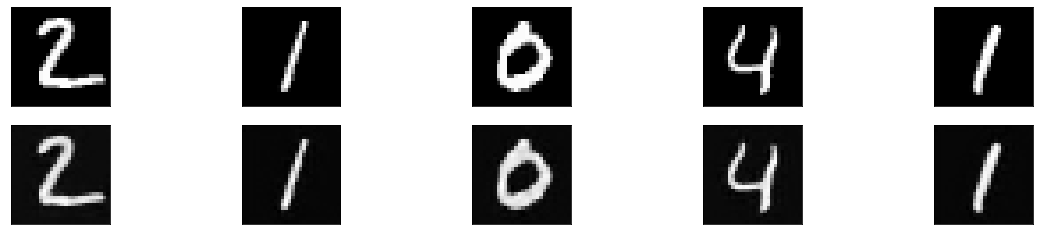

In [ ]:
ae = load_model('mnist_ae.h5')
enc = load_model('mnist_enc.h5', compile=False)

decoded_imgs = ae.predict(MNIST_x_data_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(MNIST_x_data_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
shape = (1,) + MNIST_x_data_train.shape[1:]
gamma = 100.
theta = 100.
c_init = 1.
c_steps = 2
max_iterations = 1000
feature_range = (MNIST_x_data_train.min(),MNIST_x_data_train.max())

label:  5
predicted class:  5
increasing order of predictions:  [5 6 8 9 0 4 3 2 1 7]


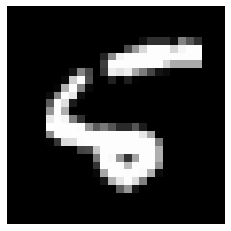

In [ ]:
X = MNIST_x_data_test[8].reshape((1,) + MNIST_x_data_test[0].shape)
plt.imshow(X.reshape(28, 28),cmap='gray');
print('label: ',MNIST_y_data_test[8])
print('predicted class: ', np.argmax(MNIST_CNN.predict(MNIST_x_data_test[8:9,:])))
print('increasing order of predictions: ', np.flip(np.argsort(MNIST_CNN.predict_proba(MNIST_x_data_test[8:9,:])).ravel()))
plt.axis('off');

In [ ]:
# initialize explainer, fit and generate counterfactual
cf = CounterFactualProto(MNIST_CNN, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
start_time = time()
cf.fit(MNIST_x_data_train)  # find class prototypes
print('Time to find prototypes each class: {:.3f} sec'.format(time() - start_time))
start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Time to find prototypes each class: 4.709 sec
Explanation took 11.531 sec


Counterfactual prediction: 9
Closest prototype class: 4


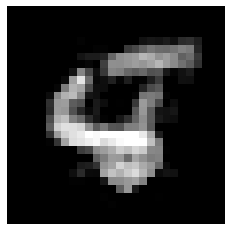

In [ ]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation.cf['X'].reshape(28, 28),cmap='gray');
plt.axis('off');

In [ ]:
# initialize explainer, fit and generate counterfactuals
#cf = CounterFactualProto(MNIST_CNN, shape, gamma=gamma, theta=theta,
#                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
#                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
#cf.fit(MNIST_x_data_train)
explanation_k1 = cf.explain(X, k=1, k_type='mean')
explanation_k20 = cf.explain(X, k=20, k_type='mean')

Counterfactual prediction: 9
Closest prototype class: 4


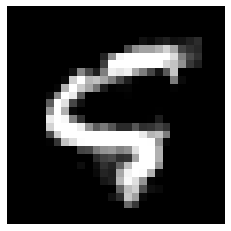

In [ ]:
print('Counterfactual prediction: {}'.format(explanation_k1.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation_k1.cf['X'].reshape(28, 28),cmap='gray')
plt.axis('off');

Counterfactual prediction: 9
Closest prototype class: 4


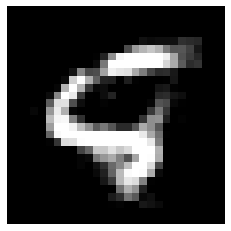

In [ ]:
print('Counterfactual prediction: {}'.format(explanation_k20.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation_k20.cf['X'].reshape(28, 28),cmap='gray')
plt.axis('off');

In [ ]:
# initialize explainer, fit and generate counterfactuals
#cf = CounterFactualProto(MNIST_CNN, shape, gamma=gamma, theta=theta,
#                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
#                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
#cf.fit(MNIST_x_data_train)
explanation_1 = cf.explain(X, k=5, k_type='mean', target_class=[6])
proto_1 = explanation_1.id_proto
explanation_2 = cf.explain(X, k=5, k_type='mean', target_class=[8])
proto_2 = explanation_2.id_proto
explanation_3 = cf.explain(X, k=5, k_type='mean', target_class=[9])
proto_3 = explanation_3.id_proto

Counterfactual prediction: 6
Closest prototype class: 6


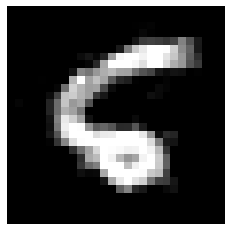

In [ ]:
print('Counterfactual prediction: {}'.format(explanation_1.cf['class']))
print(f'Closest prototype class: {proto_1}')
plt.imshow(explanation_1.cf['X'].reshape(28, 28),cmap='gray')
plt.axis('off');

Counterfactual prediction: 8
Closest prototype class: 8


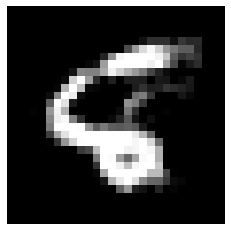

In [ ]:
print('Counterfactual prediction: {}'.format(explanation_2.cf['class']))
print(f'Closest prototype class: {proto_2}')
plt.imshow(explanation_2.cf['X'].reshape(28, 28),cmap='gray')
plt.axis('off');

Counterfactual prediction: 9
Closest prototype class: 9


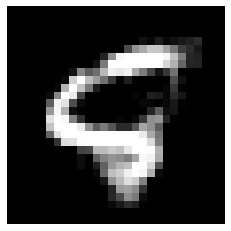

In [ ]:
print('Counterfactual prediction: {}'.format(explanation_3.cf['class']))
print(f'Closest prototype class: {proto_3}')
plt.imshow(explanation_3.cf['X'].reshape(28, 28),cmap='gray')
plt.axis('off');

# CEM

In [7]:
!pip install alibi

     |████████████████████████████████| 235kB 5.8MB/s eta 0:00:01
     |████████████████████████████████| 327kB 22.3MB/s 
     |████████████████████████████████| 394.7MB 40kB/s 
     |████████████████████████████████| 28.0MB 6.9MB/s 
     |████████████████████████████████| 10.6MB 53.0MB/s 
     |████████████████████████████████| 471kB 49.6MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463905 sha256=c8cc050af1f55f89aba6543109afbc4172391ed8ae091cec187f83c1e86f073c
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052145 sha256=ff30de113b78c9ffea90a4aa501e6350de5508f70faa4f9869ffdef772cfa64b
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built shap spacy-lookups-data
  Found existing installation: tensorboard 1.15.0
    Un

In [7]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from alibi.explainers import CEM

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

MNIST_CNN = tf.keras.models.load_model('/content/drive/My Drive/XAI/XAI Survey/code/models/Images/cnn_simple_mnist_no_pickle')
MNIST_CNN.trainable=False

(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = tf.keras.datasets.mnist.load_data()
MNIST_x_data_train = MNIST_x_data_train.reshape(-1,28,28,1)/255
MNIST_x_data_test = MNIST_x_data_test.reshape(-1,28,28,1)/255

TF version:  2.4.0
Eager execution enabled:  False


In [12]:
import time
start = time.time()

def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)

    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)

    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

ae, enc, dec = ae_model()
ae.fit(MNIST_x_data_train, MNIST_x_data_train, batch_size=128, epochs=4, validation_data=(MNIST_x_data_test, MNIST_x_data_test), verbose=0)
ae.save('mnist_ae.h5', save_format='h5')
enc.save('mnist_enc.h5', save_format='h5')
ae.load_weights('/content/drive/My Drive/XAI/XAI Survey/code/examples/guided_proto/mnist_ae.h5')
enc.load_weights('/content/drive/My Drive/XAI/XAI Survey/code/examples/guided_proto/mnist_enc.h5')

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


label:  5
predicted class:  5
increasing order of predictions:  [5 6 8 9 0 4 3 2 1 7]


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


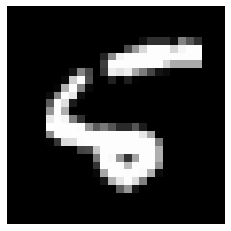

In [13]:
X = MNIST_x_data_test[8].reshape((1,) + MNIST_x_data_test[0].shape)
plt.imshow(X.reshape(28, 28),cmap='gray');
print('label: ',MNIST_y_data_test[8])
print('predicted class: ', np.argmax(MNIST_CNN.predict(MNIST_x_data_test[8:9,:])))
print('increasing order of predictions: ', np.flip(np.argsort(MNIST_CNN.predict_proba(MNIST_x_data_test[8:9,:])).ravel()))
plt.axis('off');

In [14]:
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + MNIST_x_data_train.shape[1:]  # instance shape
kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
gamma = 100  # weight of the optional auto-encoder loss term
c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (MNIST_x_data_train.min(),MNIST_x_data_train.max())  # feature range for the perturbed instance
clip = (-1000.,1000.)  # gradient clipping
lr = 1e-2  # initial learning rate
no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
                  # perturbations towards this value means removing features, and away means adding features
                  # for our MNIST images, the background (-0.5) is the least informative,
                  # so positive/negative perturbations imply adding/removing features

In [15]:
# initialize CEM explainer and explain instance
cem = CEM(MNIST_CNN, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)
print(time.time()-start)

580.8503925800323


Pertinent negative prediction: 6


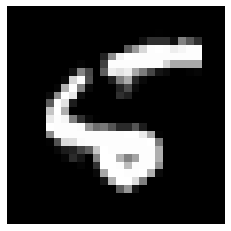

In [ ]:
print(f'Pertinent negative prediction: {explanation.PN_pred}')
plt.imshow(explanation.PN.reshape(28, 28),cmap='gray')
plt.axis('off');

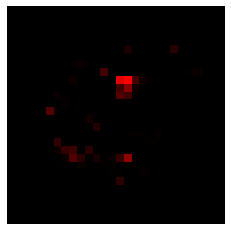

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 0, 0), (1, 0, 0)]  # R -> G -> B
cmap_name = 'my_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=150)
plt.imshow(explanation.PN.reshape(28, 28)-X.reshape(28,28),cmap=cm)
plt.axis('off');

In [ ]:
mode = 'PP'
# initialize CEM explainer and explain instance
cem = CEM(MNIST_CNN, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

Pertinent positive prediction: 5


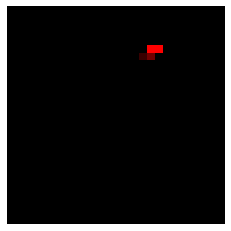

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 0, 0), (1, 0, 0)]  # R -> G -> B
cmap_name = 'my_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

print(f'Pertinent positive prediction: {explanation.PP_pred}')
plt.imshow(explanation.PP.reshape(28, 28),cmap=cm,alpha=1)
#plt.imshow(X.reshape(28,28),cmap='gray',alpha=0.5)
plt.axis('off');